In [1]:
# Copyright 2023, Acadential, All rights reserved.

# 2-6. PyTorch 기초 - Datasets와 DataLoader

## Dataset 불러오기

torchvision에서는 다양한 Computer Vision용의 benchmark dataset을 제공합니다.\
대표적으로:
1. Cifar10, Cifar100
2. MNIST
3. Fashion MNIST
4. Cityscapes

등등이 있습니다. 여기 [참고](https://pytorch.org/vision/stable/datasets.html)

이번 실습에서는 CIFAR10에 대해서 살펴보도록 하겠습니다.

참고로, CIFAR10 데이터셋이란, 10개의 클래스로 이루어진 60000개의 32x32 컬러 이미지 데이터셋입니다. 10개의 클래스는 다음과 같습니다: 
- "plane"
- "car"
- "bird"
- "cat"
- "deer"
- "dog"
- "frog"
- "horse"
- "ship"
- "truck"

즉, CIFAR10은 이미지가 주어졌을때 이 이미지가 어떤 클래스에 속하는지를 맞추는 분류하는 Classification task에 대한 데이터셋입니다.

## CIFAR10 데이터셋 불러오기



```torchvision.datasets.CIFAR10```을 통해서 데이터셋을 다운로드 받을 수 있습니다. CIFAR10은 다음과 같은 parameter을 가집니다.
1. root = dataset을 다운로드 받을 위치. 혹은 다운로드 받은 데이터셋이 저장된 위치.
2. train = train dataset인지 혹은 test dataset인지 명시
3. download = 다운로드 받을 것인지 명시
4. transform = image을 어떻게 transform할 것인지 명시 (e.g. Random Crop, Resize, ToTensor)

In [2]:
import numpy as np 
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import os 

In [3]:
# cache 폴더 생성하기
os.makedirs("../.cache", exist_ok=True)


In [4]:
# 데이터셋 불러오기
training_data = datasets.CIFAR10(
    root="../.cache",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.CIFAR10(
    root="../.cache",
    train=False,
    download=True,
    transform=ToTensor()
)

170499072it [00:25, 6789688.44it/s]                                


Extracting ../.cache/cifar-10-python.tar.gz to ../.cache
Files already downloaded and verified


### Labels map

CIFAR10 데이터셋은 각 label class을 integer로 변환시켜서 출력합니다. \
어떤 integer가 label class에 해당되는지 labels_map으로 정의해보겠습니다.

In [5]:
labels_map = {
    0: "plane",
    1: "car",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck",
}

### CIFAR10에 포함된 예시

In [6]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    
    # training_data은 img (3D tensor), label (scalar tensor)을 출력합니다.
    img, label = training_data[sample_idx]
    
    figure.add_subplot(rows, cols, i)
    
    # labels_map으로부터 출력된 (integer)로 변환된 label을 원래의 string으로 된 label로 바꾸는 것.
    plt.title(labels_map[label])
    
    plt.axis("off")
    
    # ToTensor은 PIL image (Height, Width, Channel)을 (Channel, Height, Width)로 바꿉니다.
    # 따라서 (Channel, Height, Width)로 된 tensor을 다시 (Height, Width, Channel)로 바꿔줘야합니다.
    plt.imshow(img.permute(1,2,0))
plt.show()

# 이미지 데이터 전처리

```torchvision```을 통해 ```CIFAR10``` Dataset을 불러올 수 있었습니다. 그럼 CIFAR10 데이터셋의 이미지 데이터를 어떻게 전처리하는지 살펴보도록 하겠습니다.

1. Pillow (PIL) Library로 이미지 파일 읽기
2. (PIL로 읽어온) 이미지를 numpy 배열로 변환하기
3. Numpy 배열을 Torch Tensor로 변환하기 

## Pillow (PIL) Library로 이미지 파일 읽기

이미지 데이터들은 흔히 ```.png```, ```.jpeg``` 파일 형식으로 저장됩니다. 이런 파일을 읽을때는 ```Pillow``` library의 ```PIL.Image.open```을 사용해서 읽어올 수 있습니다.

In [7]:
from PIL import Image 

In [8]:
img = Image.open("./sample_images/cat_img.jpeg")

In [9]:
size = img.size

In [10]:
img = img.resize((size[0]//8, size[1]//8))
img

## (PIL로 읽어온) 이미지를 numpy 배열로 변환하기

In [11]:
np_img = np.array(img)

In [12]:
np_img.shape  # (height, width, number of channel)

(40, 60, 3)

Height, Width, Channel 개수로 총 3개의 차원을 가지는 3차원 텐서입니다.

In [13]:
np_img.dtype  # uint8 형식을 가집니다.

dtype('uint8')

In [14]:
for each_channel in range(3):
    print(f"{each_channel}-th min value: ", np.min(np_img[:,:,each_channel]))
    print(f"{each_channel}-th max value: ", np.max(np_img[:,:,each_channel]))

0-th min value:  4
0-th max value:  247
1-th min value:  4
1-th max value:  255
2-th min value:  4
2-th max value:  255


이처럼 R, G, B channel의 각 value은 0~255 사이의 integer이다.

### 참고 사항:

Image을 numpy ndarray으로 변환하면 ndarray의 각 dimension은 ***(height, width, number of channel)*** 이다!

## PIL.Image 혹은 Numpy 배열을 Torch Tensor로 변환하기 

Numpy 배열은 Torch Tensor로 변환할 수 있고 그 반대도 가능합니다. \
```torchvision.transforms.ToTensor```를 사용하면 numpy 배열을 torch tensor로 변환할 수 있습니다.

```ToTensor```은 numpy 배열에 적용할 수도 있고, PIL.Image에 바로 적용할 수도 있습니다. (출력되는 결과는 같습니다.)

참고로 ToTensor은 이미지 데이터의 값의 범위를 0~1 사이로 normalize합니다. (0~255 사이의 integer를 0~1 사이의 float으로 변환)

## PIL.Image -> torch.Tensor

In [15]:
# ToTensor을 사용해서 PIL.Image을 tensor로 변환
tensor_img = ToTensor()(img)

In [16]:
tensor_img.shape

torch.Size([3, 40, 60])

In [17]:
for each_channel in range(3):
    print(f"{each_channel}-th min value: ", torch.min(tensor_img[each_channel,:,:]))
    print(f"{each_channel}-th max value: ", torch.max(tensor_img[each_channel,:,:]))

0-th min value:  tensor(0.0157)
0-th max value:  tensor(0.9686)
1-th min value:  tensor(0.0157)
1-th max value:  tensor(1.)
2-th min value:  tensor(0.0157)
2-th max value:  tensor(1.)


In [18]:
tensor_img.dtype

torch.float32

### ToTensor에 대한 참고 사항:

보다시피 ToTensor은 다음과 같이 바꿔줍니다:
1. Channel에 대한 차원이 맨 앞으로 오게 바꿔줍니다: 
    - (height, width, number of channels) -> (number of channels, height, width)
    - i.e. (H, W, C) -> (C, H, W)
2. 값을 255로 나눠줍니다
    - 0\~255 -> 0\~1의 값
3. uint8 -> float32
    

## np.ndarray -> torch.Tensor

Numpy ndarray에 대해서도 동일하게 적용될 수 있습니다!

In [19]:
tensor_img2 = ToTensor()(np_img)

In [20]:
tensor_img2.shape

torch.Size([3, 40, 60])

In [21]:
for each_channel in range(3):
    print(f"{each_channel}-th min value: ", torch.min(tensor_img2[each_channel,:,:]))
    print(f"{each_channel}-th max value: ", torch.max(tensor_img2[each_channel,:,:]))

0-th min value:  tensor(0.0157)
0-th max value:  tensor(0.9686)
1-th min value:  tensor(0.0157)
1-th max value:  tensor(1.)
2-th min value:  tensor(0.0157)
2-th max value:  tensor(1.)


# Dataset customize하기

Dataset을 customize하기 위해서는 ```torch.utils.data.Dataset```을 상속받아야 합니다.

In [22]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

## Dataset에서 구현해야하는 method들

Dataset에서는 다음 3가지 method들을 구현해야합니다.
1. ```__init__```
2. ```__len__```
3. ```__getitem__```

### ```__init__```
Initialization method. \
CustomImageDataset Class을 Object로 initialize할때 실행되는 함수. \
여기서 
1. annotations_file: label이 csv로 저장되어 있는 위치
2. img_dir: image들이 저장되어 있는 폴더 위치 
3. transform: image에 대한 transform 함수
4. target_transform: label에 대한 transform 함수 등을 명시한다.

### ```__len__```
Length method. \
Data의 개수가 총 몇 개인지 명시하는 함수. DataLoader에서 Dataset의 Length을 참고해서 mini-batch을 (mini-batch size) // (dataset length) 개수만큼 만든다.


### ```__getitem__```
Getitem method. \
여기서 각 data sample을 불러와서 어떻게 transform해서 tensor로 output할지 명시한다.


## DataLoader

DataLoader은 Dataset을 감싸는 함수이고 각 Data를 mini-batch로 구성하여 출력해줍니다. \
DataLoader에서 num_workers을 명시하면 해당 개수만큼 subprocess를 생성하여 데이터를 로딩합니다. (default: 0) \
그리고 pin_memory=True로 설정하면 GPU memory을 미리 확보해놓고 데이터를 GPU에 올릴 수 있게 해줍니다. (default: False) \
마지막으로 shuffle=True로 설정하면 데이터를 무작위로 sampling합니다. (default: False)


DataLoader에서는 다음과 같은 parameter을 명시해준다:
1. dataset: 
2. batch_size: mini-batch 크기
3. shuffle: 무작위 순서로 데이터를 sampling할 것인지
4. num_workers: 데이터 로딩에 사용할 subprocess 개수. 
5. pin_memory: GPU memory을 pin 할 것인지
6. drop_last: 마지막 mini-batch을 drop할 것인지.


참고로, num_workers수가 많을수록 데이터 로딩이 더 빠르지만 그만큼 CPU core개수도 충분해야합니다. (CPU core 개수보다 num_workers가 많으면 오히려 느려지는 경우 발생) \
pin_memory=True로 했을시 GPU (cuda) memory을 미리 할당, 확보시켜줘서 조금 더 빠르게 데이터를 GPU에 올릴 수 있게 해줍니다.



In [23]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 3, 32, 32])
Labels batch shape: torch.Size([64])


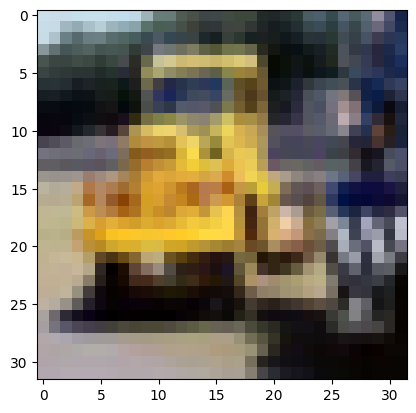

Label: 9


In [24]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img.permute(1,2,0))
plt.show()
print(f"Label: {label}")

## Iterator

참고로 iter 함수는 train_dataloader을 iterable하게 만들어주고, next 함수는 iterator로부터 다음 샘플을 샘플링한다.

In [25]:
iterator = iter([0, 1, 2, 3, 4])

In [26]:
next(iterator)

0

In [27]:
next(iterator)

1